# TP n° 1 - Entropic Coding and Compression

Adapted from Gabriel Peyré's http://www.numerical-tours.com/

This numerical tour studies source coding using entropic coders.

Entropic coding converts a vector $x\in\mathbb{N}^n$ of integers into a binary stream $y\in\{0, 1\}^N$. Entropic coding exploits the redundancies in the statistical distribution of the entries of $x$ to reduce as much as possible the number of bits $N$ of $y$. The lower bound for $N/n$ is the Shannon bound :

$$H(x)=-\sum_i p(i)\log_2 p(i)$$
where $p(i)$ is the probability of apparition of symbol $i$ in $x$.

## Imports

In [ ]:
import os
os.system("pip install ete3 pyqt5")
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

In [ ]:
import numpy as np
import ete3
import matplotlib.pyplot as plt

## Shannon Entropy

Fist we generate a simple binary signal $x$ such that $0$ has a probability $0.1$ to appear at each position of $x$.

In [ ]:
# Random binary signal `x` with length 512
x = np.random.choice([0, 1], size=512, p=[.1, .9])

One can check the probabilities by computing the empirical histogram $h$, which should sum to 1.

In [ ]:
# Compute the empirical histogram.
h = [np.sum(x == 0), np.sum(x == 1)]
h = h/np.sum(h)
print(h)

# Print the empirical probability of `0` at any position.
print("Empirical probability of `0`: %.2f" %h[0])

[0.09375 0.90625]
Empirical probability of `0`: 0.09


<div class="alert alert-block alert-info">
    <b>Question 1.</b> Compute the entropy of the histogram $h$. You may want to use <tt>np.log2</tt>.
</div>

In [ ]:
# Compute the entropy of histogram h.
entropy = ...

# Print the entropy of histogram h.
print("Entropy = %.2f" %entropy)

Entropy = 0.45


Huffman Coding
--------------
A Huffman code $C$ associates to each symbol $i$ in $\{0,\dots,K- 1\}$ a binary code $C_i$
whose length is as close as possible to the optimal bound
$-\log_2 p(i)$, where $p(i)$ is the probability of apparition of the
symbol $i$.

We select a set of proabilities for symbols $\{0, \dots, K-1\}$ for $K=5$.

In [ ]:
# Defining an histogram.
symbols = ["a", "b", "c", "d", "e"]
h = [.1, .15, .4, .15, .2]

# Checking that the sum is 1.
assert(np.sum(h) == 1)

The tree $T$ contains the codes and is generated by an iterative algorithm.
The initial "tree" is a collection of empty trees, pointing to the symbols numbers.

We build iteratively the Huffman tree
by grouping together the two trees that have the smallest probabilities.
The merged tree has a probability which is the sum of the two selected
probabilities.

In [ ]:
def make_tree(symbols, h):

    # Let us start with a list of elementary subtrees, each containing one symbol only.
    trees = [(h[i], symbols[i]) for i in range(len(h))]

    # While we have at least 2 subtrees to merge.
    while len(trees) > 1:

        # Sort according to the first values of the tuples (the probabilities)
        trees.sort()

        # Merge the two least probable subtrees, and compute their combined probability.
        merged_trees = (trees[0], trees[1])
        p_merged_trees = trees[0][0] + trees[1][0]

        # Add the merged subtree to the list of remaining subtrees.
        trees = trees[2:] + [(p_merged_trees, merged_trees)]

    # At the end, only one tree remains, the Huffman tree.
    return trees[0]

In [ ]:
tree = make_tree(symbols, h)
print(tree)

(1.0, ((0.4, 'c'), (0.6, ((0.25, ((0.1, 'a'), (0.15, 'b'))), (0.35, ((0.15, 'd'), (0.2, 'e')))))))


This is a bit hard to read, let us trim it by removing the probabilities.

In [ ]:
# Remove the probabilities from the tree.
def trim(tree):

    # Separate the probability and what it refers to.
    probability, element = tree

    # If it is a leaf, i.e. a symbol, then return it.
    if type(element) != tuple:
        return element

    # If it is a couple of subtrees, trim each one.
    else:
        left, right = element
        return (trim(left), trim(right))

In [ ]:
huffman_tree = trim(tree)
print(huffman_tree)

('c', (('a', 'b'), ('d', 'e')))


Your tree should look like this: `('c', (('a', 'b'), ('d', 'e')))`

Visualize it using `ete3`.

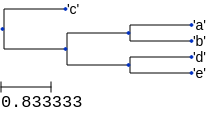

In [ ]:
# ete3 wants the tree to look like "('c', (('a', 'b'), ('d', 'e')));"
# Notice the ";"
ete3.Tree(str(huffman_tree) + ";").render("%%inline")

Once the tree $T$ is computed, one can compute the code $C_{i}$
associated to each symbol $i$. This requires to perform a deep first
search in the tree and stop at each node.

In [ ]:
# Explore a huffman tree and fill the dictionary `codes`
def codes_from_huffman(tree, codes, c):

     # If the tree is just a leaf, then note its code.
    if type(tree) != tuple:
        codes[tree] = c

    # Otherwise, continue exploring the subtrees.
    else:
        left, right = tree  # Split into left and right subtree.

        # If we go left, add a '0' to the current code.
        codes_from_huffman(left, codes, c + [0])

        # If we go right, add a '1' to the current code.
        codes_from_huffman(right, codes, c + [1])

In [ ]:
# Initialize the coding dictionary.
codes = {}

In [ ]:
# Explore our huffman tree recursively.
codes_from_huffman(huffman_tree, codes, [])

Display the code.

In [ ]:
for token in codes:
    print("Code of token " + token + ": " + str(codes[token]))

Code of token c: [0]
Code of token a: [1, 0, 0]
Code of token b: [1, 0, 1]
Code of token d: [1, 1, 0]
Code of token e: [1, 1, 1]


We draw a vector $x$ according to the distribution $h$.

In [ ]:
n = 50_000 # `n` is the size of the signal.

# Pick `n` symbols according to distribution `h`.
x = np.random.choice(symbols, size=n, p=h)

# Display the beginning of the array `x`.
print(x[:30], "...")

['c' 'c' 'c' 'c' 'b' 'e' 'd' 'b' 'c' 'a' 'd' 'a' 'e' 'b' 'b' 'e' 'c' 'a'
 'e' 'c' 'c' 'd' 'e' 'b' 'c' 'a' 'b' 'e' 'd' 'c'] ...


<div class="alert alert-block alert-info">
    <b>Question 2.</b> Implement the coding of the vector $x$ to obtain a binary vector $y$, which corresponds to replacing each sybmol $x(i)$ by the code $C_{x(i)}$. Represent $y$ as an array of 0 and 1, which should look like <tt>[1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1] ...
<tt>.
</div>

In [ ]:
def encode(x, codes):
    y = []
    for token in x:
        y = ...
    return y

y = encode(x, codes)
print(y[:30], "...")

[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1] ...


<div class="alert alert-block alert-info">
    <b>Question 3.</b> Compare the length of the code with the entropy bound.
</div>

In [ ]:
entropy_bound = ...
print("Entropy bound =", entropy_bound)

length = ...
print("Huffman code  =", length)

Entropy bound = 2.1464393446710153
Huffman code  = 2.19944


Decoding is more complicated, since it requires to iteratively parse the tree $T$.

In [ ]:
def decode(y, tree):
    decoded = []
    subtree = tree

    for bit in y:
        left, right = subtree

        if bit == 0:
            subtree = left
        else:
            subtree = right

        if type(subtree) != tuple:
            decoded.append(subtree)
            subtree = tree

    return np.array(decoded)

Perform decoding and test if it is identical to the initial signal.

In [ ]:
decoded = decode(y, huffman_tree)
assert(np.array_equal(decoded, x))

Huffman Block Coding
--------------------
A Huffman coder is inefficient because it can distribute only an integer
number of bit per symbol. In particular, distribution where one of the
symbol has a large probability are not well coded using a Huffman code.
This can be aleviated by replacing the set of $K$ symbols by $K^q$
symbols obtained by packing the symbols by blocks of $q$ (here we use $K=2$ for a binary alphabet). This breaks
symbols with large probability into many symbols with smaller probability,
thus approaching the Shannon entropy bound.

In [ ]:
# Define the probability of drawing a 0.
t = 0.12

In [ ]:
# Define the histogram (probability of 0, probability of 1).
h = [t, 1 - t]

Generate signal.

In [ ]:
# Define the number of bits to generate.
n = 2**13

# Generate a random sequence of bits with distribution h.
x = np.random.choice([0, 1], size=n, p=h)

For block of length $q=3$, create a new vector by coding each block
with an integer in $\{0,...,K^q - 1\}$. The new length of the vector is
$n_1/q$ where $n_1=\lceil n/q\rceil q$.

In [ ]:
# Define the size of one block.
q = 3

In [ ]:
def block_transform_signal(x, K, q):

    # Define the new size of the signal, which should be a multiple of the block size.
    # If n is a multiple of q, then just keep n.
    if len(x) % q == 0:
        n1 = len(x)

    # Else, we'll need to add some more bits.
    else:
        n1 = (len(x)//q + 1)*q

    # Pad the signal with extra ones at the end.
    x1 = np.ones(n1, dtype=int)
    x1[:len(x)] = x.copy()

    # Create a new signal, transforming blocks into symbols of a larger alphabet.
    x2 = []
    for i in range(0, n1, q):
        mult = K**np.arange(q)
        x2.append(np.sum(x1[i:i+q]*mult))
    return x2

In [ ]:
print(x[:30])
print(block_transform_signal(x, len(h), q)[:30], "...")

[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1]
[7, 3, 7, 7, 7, 1, 7, 7, 7, 5, 7, 7, 7, 3, 5, 7, 7, 7, 6, 7, 7, 7, 6, 6, 7, 7, 7, 7, 6, 7] ...


We generate the probability table $H$ of $x_1$ that represents the probability
of each new block symbols in $\{0,...,K^q - 1\}$.

In [ ]:
def block_transform_histogram(h, q):

    # Start from the histogram h.
    # These are the probabilities for blocks of size 1.
    H = h.copy()

    # Add a symbol every time, reaching blocks of q in the end.
    for _ in range(q - 1):

        # Make a copy of the current state.
        Hold = H.copy()

        # Iterate over possible symbols (here, 0 or 1).
        # Multiply the current state by the probability of that symbol,
        # and concatenate that to the new state.
        H = []
        for j in range(len(h)):
          for e in Hold:
            H.append(e*h[j])
    return H

In [ ]:
block_transform_histogram(h, q)

[0.001728,
 0.012672,
 0.012672,
 0.092928,
 0.012672,
 0.092928,
 0.092928,
 0.681472]

The operation in the outer loop is actually the Kronecker product, so we can simplify our code like this:

In [ ]:
def block_transform_histogram(h, q):

    # Start with blocks of 1 symbol.
    H = h.copy()

    # Add a new symbol until we have blocks of size q.
    for _ in range(q - 1):

        # The new histogram is the Kronecker product
        # between the previous one and the initial h.
        H = np.kron(H, h)

    return H

In [ ]:
block_transform_histogram(h, q)

array([0.001728, 0.012672, 0.012672, 0.092928, 0.012672, 0.092928,
       0.092928, 0.681472])

<div class="alert alert-block alert-info">
    <b>Question 4.</b> For various values of block size $k$, Perform the Huffman coding and compute the length of the code. Compare with the entropy bound.
</div>

In [ ]:
entropy_bound = -np.sum(np.log2(h)*h)
lengths = []

for q in range(1, 12):

    ...

    length =

    lengths.append(length)

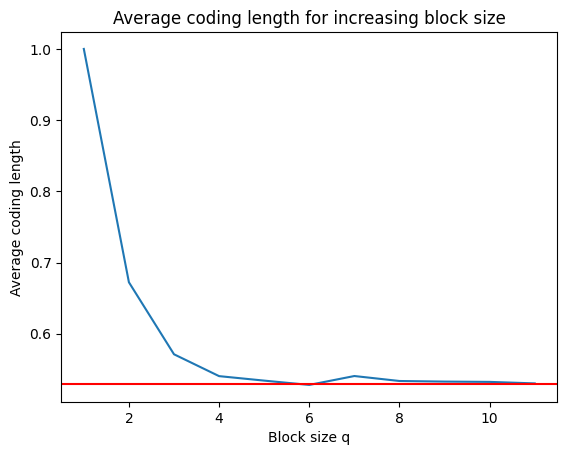

In [ ]:
plt.plot(range(1, 12), lengths)
plt.axhline(entropy_bound, c='r')
plt.title("Average coding length for increasing block size")
plt.xlabel("Block size q")
plt.ylabel("Average coding length")
plt.show()